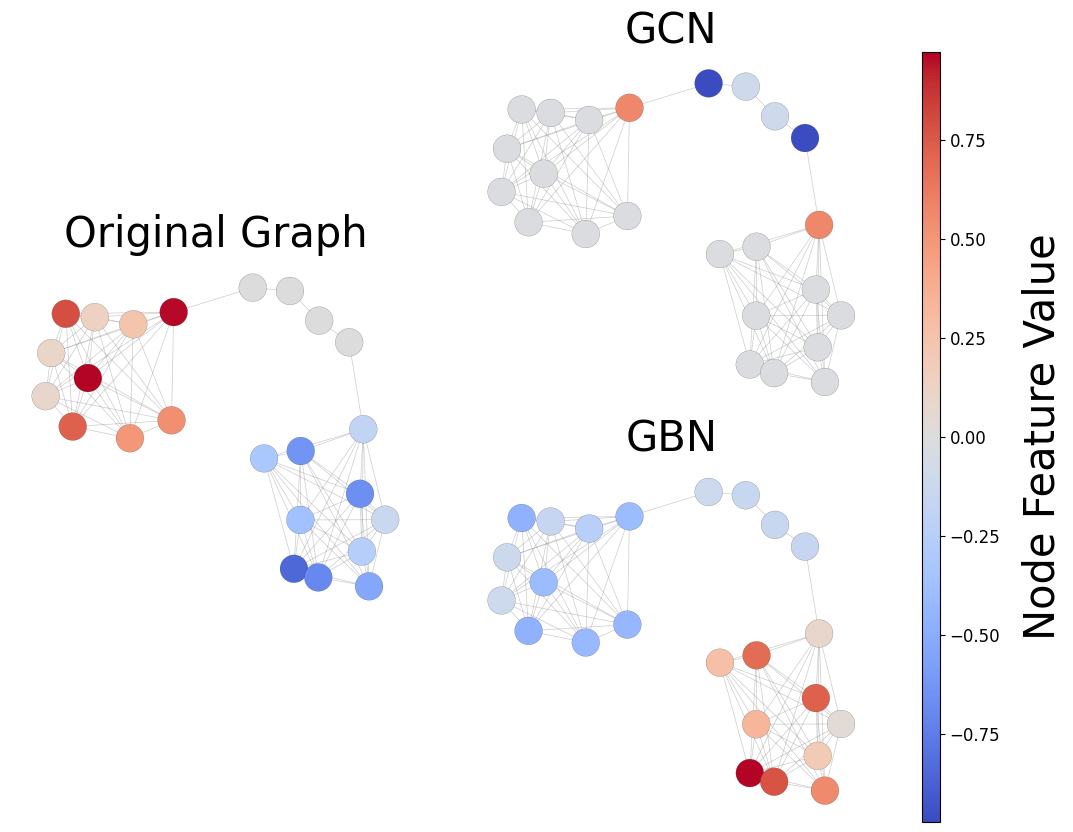

In [ ]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from torch_geometric.utils import from_networkx, to_networkx
import warnings
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec
from modules.models import BoundaryGCN, GCN
from torch.optim import Adam
import numpy as np

warnings.filterwarnings("ignore")
from utils.eval_utils import set_seed

set_seed(10)


def generate_n_clique_graph_with_attrs(clique_sizes, path_lengths, feat_dim=1):
    if len(path_lengths) != len(clique_sizes) - 1:
        raise ValueError("'path_lengths' must = clique_sizes - 1")

    cliques = [nx.complete_graph(size) for size in clique_sizes]
    offsets = [0]
    for i in range(len(clique_sizes) - 1):
        offsets.append(offsets[-1] + clique_sizes[i] + max(path_lengths[i], 1))

    for i in range(1, len(cliques)):
        cliques[i] = nx.relabel_nodes(cliques[i], {j: j + offsets[i] for j in range(clique_sizes[i])})

    paths = []
    for i, pl in enumerate(path_lengths):
        if pl > 0:
            path = nx.path_graph(pl)
            start = offsets[i] + clique_sizes[i]
            path = nx.relabel_nodes(path, {j: start + j for j in range(pl)})
            paths.append(path)

    all_graphs = []
    for i in range(len(clique_sizes)):
        all_graphs.append(cliques[i])
        if i < len(paths):
            all_graphs.append(paths[i])

    G = nx.union_all(all_graphs)

    for i in range(len(clique_sizes) - 1):
        last_prev = offsets[i] + clique_sizes[i] - 1
        if path_lengths[i] > 0:
            first_path = offsets[i] + clique_sizes[i]
            G.add_edge(last_prev, first_path)

            last_path = first_path + path_lengths[i] - 1
            first_next = offsets[i + 1]
            G.add_edge(last_path, first_next)
        else:
            first_next = offsets[i + 1]
            G.add_edge(last_prev, first_next)

    pyg_graph = from_networkx(G)
    num_nodes = offsets[-1] + clique_sizes[-1]
    node_features = torch.zeros((num_nodes, feat_dim))
    node_types = torch.zeros(num_nodes)

    for i, pl in enumerate(path_lengths):
        if pl > 0:
            start = offsets[i] + clique_sizes[i]
            node_types[start:start + pl] = 0  
            node_features[start:start + pl] = 0

    for i, size in enumerate(clique_sizes):
        start = offsets[i]
        if i % 2 == 0:  
            node_types[start:start + size] = -1
            node_features[start:start + size] = -torch.rand(size, feat_dim)
        else:  
            node_types[start:start + size] = 1
            node_features[start:start + size] = torch.rand(size, feat_dim)
    nx_graph = G
    degrees = dict(nx_graph.degree())
    left_clique_nodes = set(range(offsets[0], offsets[0] + clique_sizes[0]))
    right_clique_nodes = set(range(offsets[-1], offsets[-1] + clique_sizes[-1]))

    for u, v in nx_graph.edges():
        deg_u = degrees[u]
        deg_v = degrees[v]
        base_weight = 1 / (deg_u * deg_v + 1e-6)

        if (u in left_clique_nodes or u in right_clique_nodes) and (v in left_clique_nodes or v in right_clique_nodes):
            weight = base_weight*0.4
        else:
            weight = base_weight
        nx_graph[u][v]['weight'] = weight

    pyg_graph = from_networkx(nx_graph)
    pyg_graph.x = node_features
    pyg_graph.node_type = node_types

    return pyg_graph, nx_graph



if __name__ == '__main__':

    node_size = 400  
    edge_alpha = 0.4  
    edge_width = 0.5  
    font_size = 30  
    edge_color = 'gray'  
    node_edge_color = 'black'
    node_linewidth = 0.1  
    layout_iterations = 50  

    # 
    clique_sizes = [10, 10]
    path_lengths = [4]
    feat_dim = 1
    # 
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BoundaryGCN(n_layers=12,
                        in_dim=1, hid_dim=64,
                        embed_dim=64, out_dim=1,
                        bias=True, act="gelu", input_act="gelu",
                        drop=0.0, norm='bn',
                        add_self_loop=False, tau=0.01, layer_wise=True).to(device)
    gcn = GCN(n_layers=12,
              in_dim=1, hid_dim=64,
              embed_dim=64, out_dim=1,
              bias=True, act="gelu", input_act="gelu",
              drop=0.0, norm='bn').to(device)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0)

    pyg_graph, nx_graph = generate_n_clique_graph_with_attrs(clique_sizes, path_lengths, feat_dim)


    x_raw_values = pyg_graph.x.cpu().numpy().flatten()
    # our
    x_gbn = model(pyg_graph.to(device))
    out_pyg_graph = pyg_graph.clone()
    out_pyg_graph.x = x_gbn
    out_nx_graph = to_networkx(out_pyg_graph)
    x_gbn_values = out_pyg_graph.x.detach().cpu().numpy().flatten()
    # gcn
    x_gcn = gcn(pyg_graph.to(device))
    out_pyg_graph = pyg_graph.clone()
    out_pyg_graph.x = x_gcn
    out_nx_graph = to_networkx(out_pyg_graph)
    x_gcn_values = out_pyg_graph.x.detach().cpu().numpy().flatten()


    pos = nx.spring_layout(
        nx_graph,
        weight='weight',
        iterations=50,
        seed=14,
        k=None  
    )

    fig = plt.figure(figsize=(12, 10))

    gs = GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.1], height_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.3)
    ax1 = fig.add_subplot(gs[1:3, 0:2])
    ax2 = fig.add_subplot(gs[0:2, 2:4])
    ax3 = fig.add_subplot(gs[2:4, 2:4])
    cax = fig.add_subplot(gs[:, 4])

    # 
    all_values = np.concatenate([x_raw_values])
    abs_max = max(np.abs(all_values.min()), np.abs(all_values.max()))
    norm_1 = Normalize(vmin=-abs_max, vmax=abs_max)
    cmap = plt.get_cmap('coolwarm')
    node_colors = [cmap(norm_1(val)) for val in x_raw_values]
    nx.draw_networkx_nodes(
        nx_graph, pos,
        node_color=node_colors,
        node_size=node_size,
        edgecolors=node_edge_color,  
        linewidths=node_linewidth, 
        ax=ax1
    )
    nx.draw_networkx_edges(
        nx_graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        width=edge_width,  
        ax=ax1
    )
    ax1.set_title("Original Graph", fontsize=font_size)
    ax1.axis('off')

    # GCN 
    all_values = np.concatenate([x_gcn_values])
    abs_max = max(np.abs(all_values.min()), np.abs(all_values.max()))
    norm = Normalize(vmin=-abs_max, vmax=abs_max)
    cmap = plt.get_cmap('coolwarm')
    node_colors = [cmap(norm(val)) for val in x_gcn_values]
    nx.draw_networkx_nodes(
        nx_graph, pos,
        node_color=node_colors,
        node_size=node_size,
        edgecolors=node_edge_color,  
        linewidths=node_linewidth,  
        ax=ax2
    )
    nx.draw_networkx_edges(
        nx_graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        width=edge_width, 
        ax=ax2
    )
    ax2.set_title("GCN", fontsize=font_size)
    ax2.axis('off')

    # GBN 
    all_values = np.concatenate([x_gbn_values])
    abs_max = max(np.abs(all_values.min()), np.abs(all_values.max()))
    norm = Normalize(vmin=-abs_max, vmax=abs_max)
    cmap = plt.get_cmap('coolwarm')
    node_colors = [cmap(norm(val)) for val in x_gbn_values]
    nx.draw_networkx_nodes(
        nx_graph, pos,
        node_color=node_colors,
        node_size=node_size,
        edgecolors=node_edge_color,  
        linewidths=node_linewidth,  
        ax=ax3
    )
    nx.draw_networkx_edges(
        nx_graph, pos,
        edge_color=edge_color,
        alpha=edge_alpha,
        width=edge_width, 
        ax=ax3
    )
    ax3.set_title("GBN", fontsize=font_size)
    ax3.axis('off')

    # colorbar
    sm = ScalarMappable(norm=norm_1, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Node Feature Value', rotation=90, labelpad=15, fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size - 18)

    plt.tight_layout()
    plt.savefig("case_study1.pdf", format='pdf', dpi=300)
    plt.show()
